# Unsupervised Learning
## KMeans Assignment

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sqlalchemy import create_engine

## 1. Get the silhouette coefficient of the two cluster k-means solution. You'll notice that the silhouette coefficient will turn out to be greater than the one above where cluster number is three. We know that the Iris dataset consists of three different clusters. How do you explain that the silhouette score of the solution with the number of clusters being equal to the correct number of classes is lower than the one where the number of clusters is different from the correct number of classes?

In [5]:
# Load the dataset
iris = datasets.load_iris()
X = iris.data
Y = iris.target

# Scale the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

X_std.shape

(150, 4)

In [8]:
k_means = KMeans(n_clusters=2, random_state=123)

k_means.fit(X_std)

y_pred = k_means.predict(X_std)

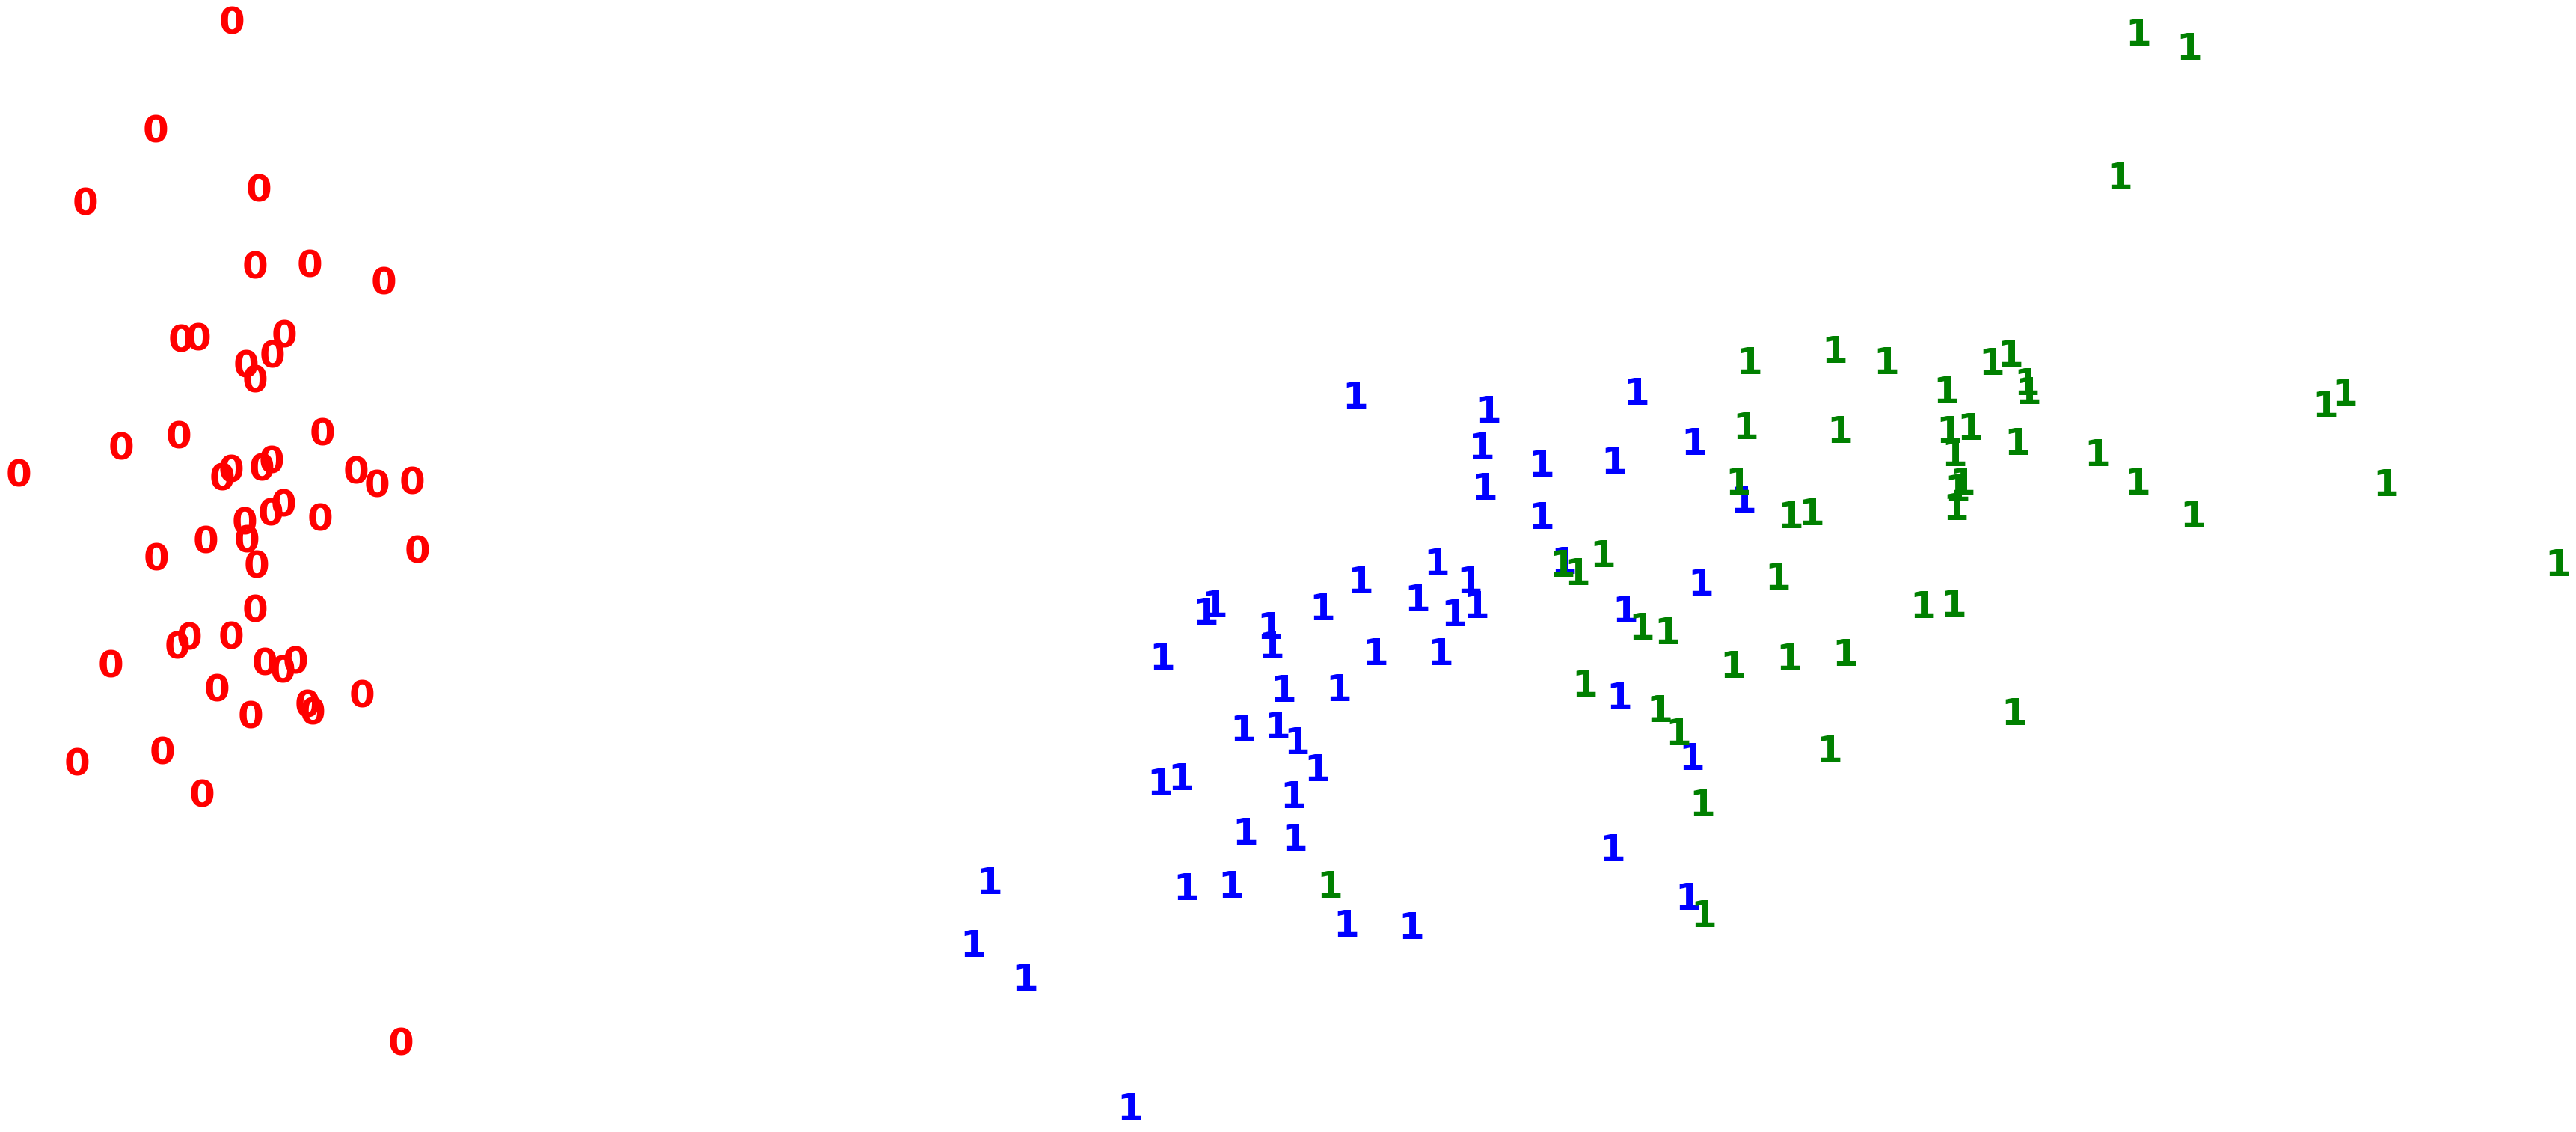

In [9]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(y_pred[i]),
             color=colours[Y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [11]:
from sklearn.metrics import silhouette_score

silhouette_score(X_std, y_pred, metric='euclidean')

0.5817500491982808

In [12]:
k_means = KMeans(n_clusters=3, random_state=123)

k_means.fit(X_std)

y_pred = k_means.predict(X_std)

silhouette_score(X_std, y_pred, metric='euclidean')

0.45994823920518635

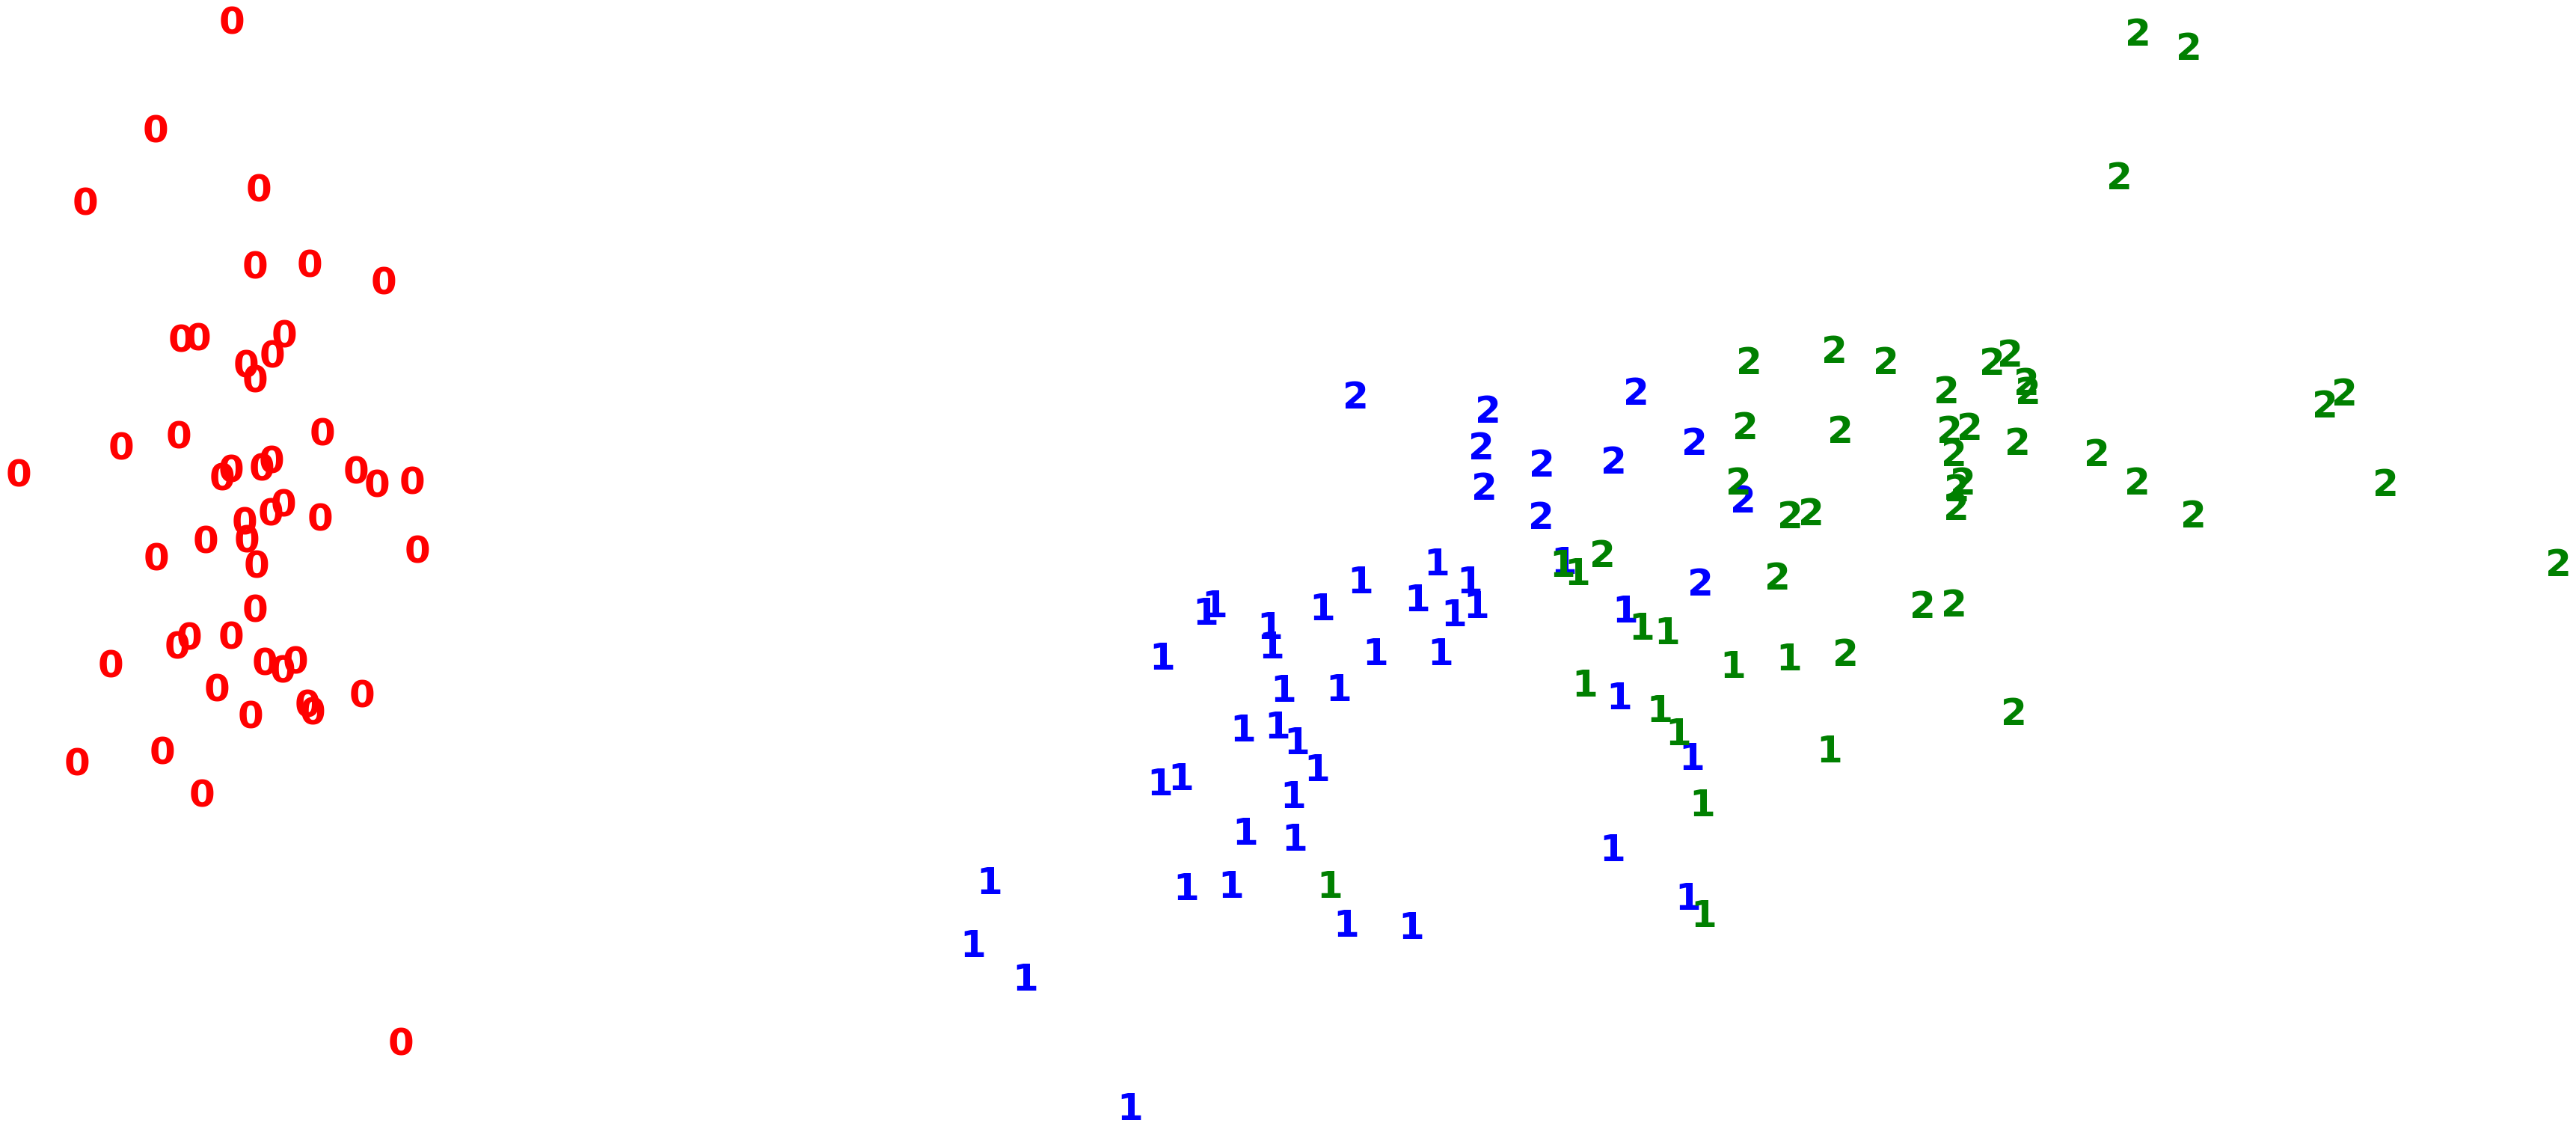

In [13]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(y_pred[i]),
             color=colours[Y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

Because to of the three clusters have such overlap, the silhouette metric is not as strong with the correct number of cluster as it is with the incorrect number.

## 2. In this assignment, you'll be working with the heart disease dataset from the UC Irvine Machine Learning Repository.


### 1. Split the data randomly into two and apply k-means using two, three and four as the number of clusters as we did in our discussion of the consistency in this checkpoint. Assess the consistency of the solutions using visualization. Which one does seem to be the best one?

In [14]:
# Load the dataset
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

data = pd.read_sql('SELECT * FROM heartdisease', con=engine)

engine.dispose()

In [39]:
# Make sure the number of rows divides evenly into four samples.
rows = data.shape[0] - data.shape[0] % 2
heartdisease_df = data.iloc[:rows, :]

In [40]:
# Define the features and the outcome
X = heartdisease_df.iloc[:, :13]
y = heartdisease_df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis
y = np.where(y > 0, 0, 1)

In [41]:
scaler = StandardScaler()

X_std = scaler.fit_transform(X)

In [42]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

In [43]:
from sklearn.model_selection import train_test_split
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=13579)

In [46]:
ypred = pd.DataFrame()

for counter, data in enumerate([
    (X_half1, X_pcahalf1), 
    (X_half2, X_pcahalf2)]):

    #put the features (f1, f2) of pca into y_pred
    ypred['pca_f1'+ '_sample'+ str(counter)] = data[1][:, 0]
    ypred['pca_f2'+ '_sample'+ str(counter)] = data[1][:, 1]

    #generate cluster predictions and store them for clusters 2 -4
    for nclust in range(2,5):
      pred= KMeans(n_clusters=nclust, random_state=3).fit_predict(data[counter])
      ypred['clust'+ str(nclust) +'_sample'+ str(counter)] = pred

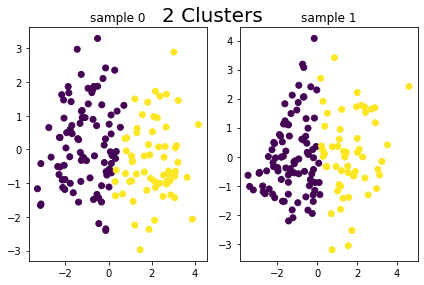

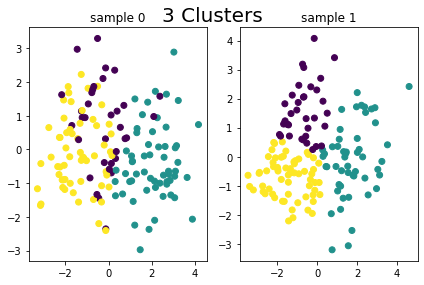

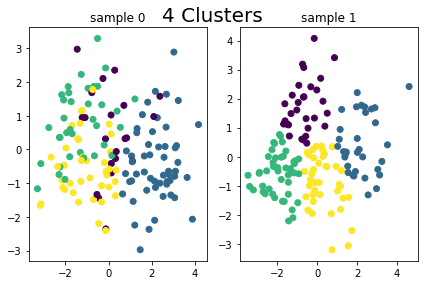

In [47]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

The samples with only 2 clusters are easily the most consistent.

### 2. Apply k-means on the whole dataset by setting k is equal two, three and four and get ARI score for each of them. Which model is the best?

In [49]:
for nclust in range(2, 5):
    full_pred = KMeans(n_clusters=nclust).fit_predict(X_std)
    print(pd.crosstab(y, full_pred))

col_0    0    1
row_0          
0       38  101
1      150   13
col_0   0   1   2
row_0            
0      35  10  94
1      85  68  10
col_0   0   1   2   3
row_0                
0      31  21  77  10
1      76  15   9  63


In [51]:
from sklearn import metrics
for nclust in range(2, 5):
    full_pred = KMeans(n_clusters=nclust).fit_predict(X_std)
    print(str(nclust) + ':', metrics.adjusted_rand_score(y, full_pred))

2: 0.43661540614807665
3: 0.27438476155143704
4: 0.1974304705701106


The number of clusters in the model that performs best when compared to random prediction is 2.

### 3. Apply k-means on the whole dataset by setting k is equal two, three and four and get silhouette coefficient for each of them. Which model is the best?/

In [52]:
for nclust in range(2,5):
    full_pred = KMeans(n_clusters=nclust).fit_predict(X_std)
    print(metrics.silhouette_score(X_std, full_pred, metric='euclidean'))

0.17440650461256255
0.12836774655637848
0.13218517271259397


The best sillhouette score is also the model with 2 clusters